<a href="https://colab.research.google.com/github/GuiSSMartins/DTx-Project/blob/main/DTx_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from graphviz import Digraph # para representação gráfica de grafos direcionados (utiliza linguagem dot)
import matplotlib.image as mpimg # operações relacionadas a imagens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc #importing garbage collector
import time

In [82]:
# df_prices = pd.read_csv('sell_prices.csv')

# função para reduzir a dimensão de um dataset
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# diminuir o tamanho dos datasets
#df_prices = reduce_mem_usage(df_prices)

In [83]:
# Represenção do digrafo, aplicando cores e percentagens nas arrestas
dot = Digraph(comment='Grafo para descrever a Estrutura do Dados')

dot.node('A', f'Total de estados', color='lightblue2', style='filled')
dot.node('B', f'Estado CA', color='lightblue2', style='filled')
dot.node('C', f'Estado TX', color='lightblue2', style='filled')
dot.node('D', f'Estado W', color='lightblue2', style='filled')
dot.node('E', f'LOJA 1', color='lightblue2', style='filled')
dot.node('F', f'LOJA 2', color='lightblue2', style='filled')
dot.node('G', f'LOJA 3', color='lightblue2', style='filled')
dot.node('H', f'LOJA 4', color='lightblue2', style='filled')
dot.node('I', f'LOJA 1', color='lightblue2', style='filled')
dot.node('J', f'LOJA 2', color='lightblue2', style='filled')
dot.node('K', f'LOJA 3', color='lightblue2', style='filled')
dot.node('L', f'LOJA 1', color='lightblue2', style='filled')
dot.node('M', f'LOJA 2', color='lightblue2', style='filled')
dot.node('N', f'LOJA 3', color='lightblue2', style='filled')
dot.node('JA', f'CATEGORY HOBBIES', color='lightblue2', style='filled')
dot.node('JB', f'CATEGORY FOOD', color='lightblue2', style='filled')
dot.node('JC', f'CATEGORY HOUSEHOLD', color='lightblue2', style='filled')
dot.node('JAA', f'DEPARTAMENT HOBBIES 1', color='lightblue2', style='filled')
dot.node('JAB', f'DEPARTAMENT HOBBIES 2', color='lightblue2', style='filled')
dot.node('JBA', f'DEPARTAMENT FOOD 1', color='lightblue2', style='filled')
dot.node('JBB', f'DEPARTAMENT FOOD 2', color='lightblue2', style='filled')
dot.node('JBC', f'DEPARTAMENT FOOD 3', color='lightblue2', style='filled')
dot.node('JCA', f'DEPARTAMENT HOUSEHOLD 1', color='lightblue2', style='filled')
dot.node('JCB', f'DEPARTAMENT HOUSEHOLD 2', color='lightblue2', style='filled')


dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('A', 'D')
dot.edge('B', 'E')
dot.edge('B', 'F')
dot.edge('B', 'G')
dot.edge('B', 'H')
dot.edge('C', 'I')
dot.edge('C', 'J')
dot.edge('C', 'K')
dot.edge('D', 'L')
dot.edge('D', 'M')
dot.edge('D', 'N')
dot.edge('J', 'JA')
dot.edge('J', 'JB')
dot.edge('J', 'JC')
dot.edge('JA', 'JAA')
dot.edge('JA', 'JAB')
dot.edge('JB', 'JBA')
dot.edge('JB', 'JBB')
dot.edge('JB', 'JBC')
dot.edge('JC', 'JCA')
dot.edge('JC', 'JCB')

dot.render('/content/drive/MyDrive/Save/patient_dot', format='png', cleanup=True)

'/content/drive/MyDrive/Save/patient_dot.png'

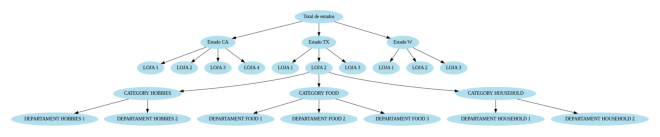

In [84]:
image = mpimg.imread('/content/drive/MyDrive/Save/patient_dot.png')

fig, ax = plt.subplots() #criar uma subparcela única
ax.imshow(image) #exibir a imagem na subparcela e desativar os eixos
ax.axis('off')
#centralizar a imagem na subparcela
ax.set_position([0, 0, 1, 1])  # Define a posição da subparcela para cobrir toda a figura
#fig.savefig("/content/drive/MyDrive/Save/patient_dot.png")
plt.show() #pode nem ser colocado

### A análise exploratória dos dados e as suas coneções passam a ser feitas no KNIME!!!!!!

## Decomposição da Série Temporal

In [85]:
df_loja1_serie_temporal_agregada = pd.read_csv('loja1.csv')

import numpy as np
import tensorflow as tf

df_loja1_serie_temporal_agregada = reduce_mem_usage(df_loja1_serie_temporal_agregada)

n_periods = 1913

# eliminar as colunas indesejadas para a construção da série temporal
df_time_series = pd.DataFrame(data={"Vendas": df_loja1_serie_temporal_agregada['Vendas_do_dia'].tolist()}, index=df_loja1_serie_temporal_agregada['date'])

Mem. usage decreased to  0.05 Mb (63.8% reduction)


In [86]:
df_loja1_serie_temporal_agregada

,date,wm_yr_wk,wday,month,year,d,Vendas_do_dia,n_eventos,week_group
0,2011-01-29,11101,1,1,2011,d_1,4337,0,0
1,2011-01-30,11101,2,1,2011,d_2,4155,0,0
2,2011-01-31,11101,3,1,2011,d_3,2816,0,1
3,2011-02-01,11101,4,2,2011,d_4,3051,0,1
4,2011-02-02,11101,5,2,2011,d_5,2630,0,1
...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,3722,0,1
1909,2016-04-21,11612,6,4,2016,d_1910,3709,0,1
1910,2016-04-22,11612,7,4,2016,d_1911,4387,0,1
1911,2016-04-23,11613,1,4,2016,d_1912,5577,0,0


In [87]:
print(df_loja1_serie_temporal_agregada.columns)

Index(['date', 'wm_yr_wk', 'wday', 'month', 'year', 'd', 'Vendas_do_dia',
       'n_eventos', 'week_group'],
      dtype='object')


In [88]:
print(df_time_series)

            Vendas
date              
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
...            ...
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113

[1913 rows x 1 columns]


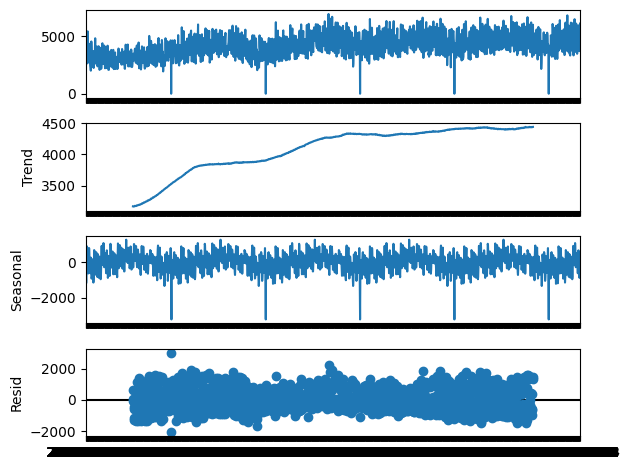

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_time_series, model='additive', period=365)
decomposition.plot()
plt.show()

## Carregar dados (agora concatenados)

In [90]:
df_loja1_RNN = reduce_mem_usage(df_loja1_serie_temporal_agregada)

#reduce_mem_usage(df_loja1_serie_temporal_agregada)

Mem. usage decreased to  0.05 Mb (0.0% reduction)


# Treino de Modelos

##### Rede Neuronal Recurrente (RNN)

In [91]:
'''import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Assuming df_loja1_RNN is your DataFrame
# You should load or define your DataFrame here

num_samples = 1913  # Assuming this is the correct number of samples
time_steps = 30
input_features = 3
output_features = 1

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly

# Convert DataFrame columns to NumPy arrays
X = selected_input_columns.values
Y = selected_output_column.values

# Calculate the number of sequences based on available samples and desired time steps
num_sequences = num_samples // time_steps

# Truncate the input and output data to fit the number of sequences#
X_truncated = X[:num_sequences * time_steps].reshape(num_sequences, time_steps, input_features)
Y_truncated = Y[(time_steps + 1):(num_sequences * time_steps + 1)].reshape(num_sequences, time_steps, output_features)
'''

'import pandas as pd\nimport numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, SimpleRNN\n\n# Assuming df_loja1_RNN is your DataFrame\n# You should load or define your DataFrame here\n\nnum_samples = 1913  # Assuming this is the correct number of samples\ntime_steps = 30\ninput_features = 3\noutput_features = 1\n\n# Select specific input and output columns\n# Assuming df_loja1_RNN is your DataFrame\nselected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8]]  # Access columns using .iloc method\nselected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly\n\n# Convert DataFrame columns to NumPy arrays\nX = selected_input_columns.values\nY = selected_output_column.values\n\n# Calculate the number of sequences based on available samples and desired time steps\nnum_sequences = num_samples // time_steps\n\n# Truncate the input and output data to fit the number of sequences#\nX_truncated = X[

In [102]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import StandardScaler

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8, 6]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

print(selected_output_column.values)

# Fit scaler to the data and transform it
selected_input_columns = scaler.fit_transform(selected_input_columns)
selected_output_column = scaler.fit_transform(selected_output_column.values.reshape(-1, 1))

# Assuming you're using TensorFlow's timeseries_dataset_from_array
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

input_data = selected_input_columns[:-7]
targets = selected_output_column[7:]
dataset = timeseries_dataset_from_array(
    input_data, targets, sequence_length=7)
for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], selected_input_columns[:7])  # First sequence: steps [0-9]
    # Corresponding target: step 10
    assert np.array_equal(targets[0], selected_output_column[7])
    break

[4337 4155 2816 ... 4387 5577 6113]


In [103]:
len(dataset)

15

In [94]:
inputs, targets = batch

inputs

<tf.Tensor: shape=(128, 7, 4), dtype=float64, numpy=
array([[[-1.58399083e+00, -1.49820503e+00, -2.92095172e-01,
         -1.57825090e+00],
        [-1.58399083e+00, -9.98367879e-01, -2.92095172e-01,
         -1.57825090e+00],
        [-1.58399083e+00, -4.98530728e-01, -2.92095172e-01,
          6.33612817e-01],
        ...,
        [-1.58399083e+00,  5.01143573e-01, -2.92095172e-01,
          6.33612817e-01],
        [-1.58399083e+00,  1.00098072e+00, -2.92095172e-01,
          6.33612817e-01],
        [-1.58399083e+00,  1.50081787e+00, -2.92095172e-01,
          6.33612817e-01]],

       [[-1.58399083e+00, -9.98367879e-01, -2.92095172e-01,
         -1.57825090e+00],
        [-1.58399083e+00, -4.98530728e-01, -2.92095172e-01,
          6.33612817e-01],
        [-1.58399083e+00,  1.30642224e-03, -2.92095172e-01,
          6.33612817e-01],
        ...,
        [-1.58399083e+00,  1.00098072e+00, -2.92095172e-01,
          6.33612817e-01],
        [-1.58399083e+00,  1.50081787e+00, -2.920

In [95]:
targets

<tf.Tensor: shape=(128, 1), dtype=float64, numpy=
array([[ 1.42482683],
       [ 0.3185205 ],
       [-0.87451539],
       [-1.03788971],
       [-1.32530749],
       [-1.1054581 ],
       [-0.95418559],
       [ 0.2943169 ],
       [ 0.33263927],
       [-1.27790877],
       [-1.60768285],
       [-1.76702323],
       [-2.03225437],
       [-1.01772004],
       [ 0.53332747],
       [-0.0586523 ],
       [-0.76660767],
       [-1.59658953],
       [-1.66113247],
       [-1.62381858],
       [-1.33438384],
       [-0.30774771],
       [-0.48019837],
       [-1.7932438 ],
       [-1.48767332],
       [-1.47758849],
       [-1.46851213],
       [-1.05503393],
       [ 0.07245055],
       [ 0.81469435],
       [-0.89367658],
       [-1.03587274],
       [-1.26278152],
       [-1.38581649],
       [-0.78173492],
       [ 0.09060325],
       [ 0.07043358],
       [-1.1538653 ],
       [-1.65407309],
       [-1.51490237],
       [-1.60264043],
       [-1.29101905],
       [ 0.11884078],
    

In [104]:
# Define the RNN model

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional

model = Sequential([
    Bidirectional(SimpleRNN(320, return_sequences=True), input_shape=(10, 5)),
    Bidirectional(SimpleRNN(320, return_sequences=False)),
    Dense(320, activation='relu'),
    Dense(1)
])
'''


#'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout

# Define the RNN model

model = Sequential([
    LSTM(50, input_shape=(7, 5), return_sequences=True),  # LSTM layer with return_sequences=True to return sequences
    Dropout(0.2),  # Dropout layer to prevent overfitting
    LSTM(50, return_sequences=False),  # Another LSTM layer without returning sequences
    Dropout(0.2),  # Dropout layer
    Dense(10, activation='relu'),  # Dense layer with ReLU activation
    Dense(1)  # Output layer
])
#'''

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=40
model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (10,5)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
layer_2_units=300
model.add(LSTM(units = layer_2_units, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=300
model.add(LSTM(units = layer_3_units))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
'''

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(dataset, epochs=100)

Epoch 1/100
15/15 [==============================] - 4s 27ms/step - loss: 0.7948
Epoch 2/100
15/15 [==============================] - 0s 27ms/step - loss: 0.7322
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 0.6266
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 0.4707
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 0.4105
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 0.3870
Epoch 7/100
15/15 [==============================] - 0s 30ms/step - loss: 0.3592
Epoch 8/100
15/15 [==============================] - 0s 28ms/step - loss: 0.3636
Epoch 9/100
15/15 [==============================] - 0s 27ms/step - loss: 0.3707
Epoch 10/100
15/15 [==============================] - 1s 48ms/step - loss: 0.4240
Epoch 11/100
15/15 [==============================] - 1s 42ms/step - loss: 0.4490
Epoch 12/100
15/15 [==============================] - 0s 28ms/step - loss: 0.3948
Epoch 13/100
15/15 [=====

In [105]:
# Make predictions
predictions = model.predict(dataset)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

print("Predictions:")
print(predictions)

15/15 [==============================] - 1s 17ms/step
Predictions:
[[4182.6396]
 [4450.2637]
 [3348.9507]
 ...
 [5511.231 ]
 [5645.9683]
 [4147.2446]]


[2514.7666 2521.2534 2546.8003 ... 6069.6816 6139.509  6231.4946]
[1 1 1 ... 1 1 1]


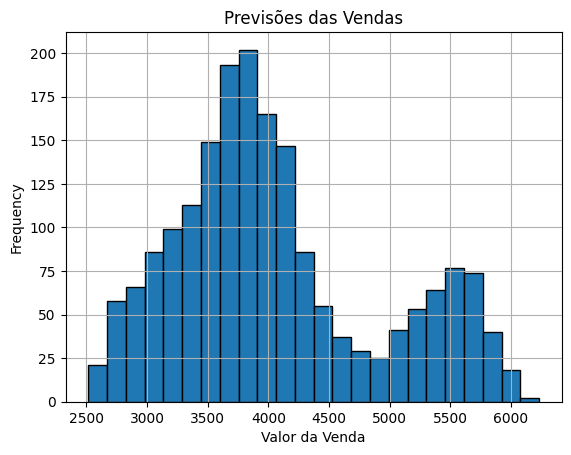

In [106]:
# Flatten the array of arrays into a single list
flat_data = [item for sublist in predictions for item in sublist]

# Count the frequency of each item
unique_items, frequencies = np.unique(flat_data, return_counts=True)

print(unique_items)
print(frequencies)

# Assuming you have a list of data points called 'data'
plt.hist(predictions, bins='auto', edgecolor='black')  # 'auto' for automatic bin size determination
plt.xlabel('Valor da Venda')
plt.ylabel('Frequency')
plt.title('Previsões das Vendas')
plt.grid(True)  # Add grid lines
plt.show()

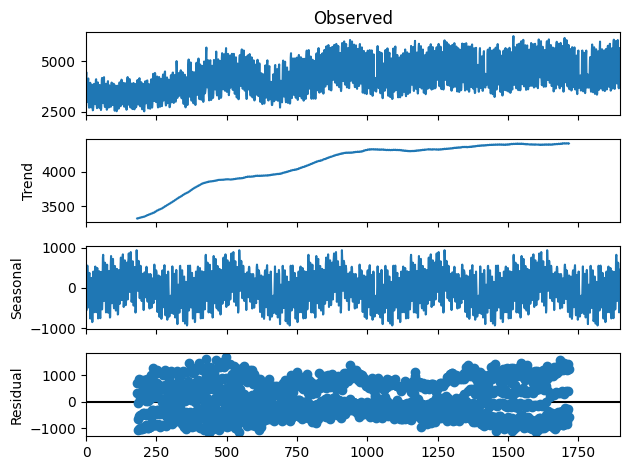

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(predictions, model='additive', period=365)
decomposition.plot()
plt.show()

### Monte-Carlo dropout

In [100]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense, Lambda
import keras.backend as K
import numpy as np

# Função para amostrar usando Monte Carlo Dropout
def mc_dropout(x):
    # Aplicar dropout
    output_with_dropout = K.dropout(x, level=dropout_rate)
    return output_with_dropout

# Definindo parâmetros de Monte Carlo Dropout
num_samples = 10  # Número de amostras de dropout
dropout_rate = 0.2  # Taxa de dropout

# Input
inputs = Input(shape=(7, 5))

# LSTM com Monte Carlo Dropout
lstm_output = LSTM(320, return_sequences=True)(inputs)
lstm_output_dropout = Lambda(mc_dropout)(lstm_output)
dropout_layer = Dropout(0.2)(lstm_output_dropout)

# LSTM com Monte Carlo Dropout
lstm_output2 = LSTM(320, return_sequences=False)(dropout_layer)
lstm_output2_dropout = Lambda(mc_dropout)(lstm_output2)
dropout_layer2 = Dropout(0.2)(lstm_output2_dropout)

# Camadas densas
dense_output = Dense(320, activation='relu')(dropout_layer2)
dense_output_dropout = Lambda(mc_dropout)(dense_output)
dropout_layer3 = Dropout(0.2)(dense_output_dropout)

# Camada de saída
output = Dense(1)(dropout_layer3)

# Modelo final
model = Model(inputs=inputs, outputs=output)

In [101]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

import numpy as np

# Train the model with Monte Carlo Dropout
def train_with_mc_dropout(model, dataset, num_epochs, num_samples):
    for epoch in range(num_epochs):
        # Inicialize as listas para armazenar as previsões de cada amostra
        predictions = []
        x_train = []
        y_train = []

        max_batch_size = max(len(batch_data) for batch_data, _ in dataset)

        for _ in range(num_samples):
            # Realize uma amostragem com dropout ativado
            preds = []
            for batch_data, batch_labels in dataset:
                # Preencha os lotes com zeros para igualar o tamanho
                padded_batch_data = np.zeros((max_batch_size, batch_data.shape[1], batch_data.shape[2]))
                padded_batch_labels = np.zeros((max_batch_size, batch_labels.shape[1]))
                padded_batch_data[:batch_data.shape[0], :, :] = batch_data
                padded_batch_labels[:batch_labels.shape[0], :] = batch_labels

                pred = model.predict(padded_batch_data)
                preds.append(pred)
                x_train.append(padded_batch_data)
                y_train.append(padded_batch_labels)
            predictions.append(np.vstack(preds))  # Empilha os resultados das previsões em um array

        # Calcule a média e variância das previsões
        mean_predictions = np.mean(predictions, axis=0)
        variance_predictions = np.var(predictions, axis=0)

        # Converta os dados de entrada e saída em numpy arrays
        x_train = np.vstack(x_train)
        y_train = np.vstack(y_train)

        # Treine o modelo com os dados e alvos do conjunto de dados
        model.train_on_batch(x_train, mean_predictions)

        # Print progresso do treinamento
        if epoch % 10 == 0:
            print("Epoch {}/{} - Loss: {:.4f}".format(epoch+1, num_epochs, np.mean(np.abs(mean_predictions - y_train))))

# Train the model
num_epochs = 30
num_samples = 10
train_with_mc_dropout(model, dataset, num_epochs, num_samples)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 7, 5), found shape=(32, 7, 4)


# IGNORAR

A partir daqui, tem apenas código auxiliar para ajudar a obter uma versão reduzida dos dados. Por isso, irá ficar tudo em comentário.





In [ ]:
'''

# (Prices preços) Reduzir os dados para apenas de uma loja

df_prices = pd.read_csv('sell_prices.csv')

csv_path = "df_prices_Loja1.csv"
id_loja = "CA_1"
coluna = "store_id"

# Ler o arquivo CSV existente, se houver
try:
    df_existing = pd.read_csv(csv_path)
except FileNotFoundError:
    df_existing = pd.DataFrame()

index = 0
still_searching = True

while still_searching:
    actual_price = df_prices.iloc[index]
    loja = actual_price[coluna]
    if loja == id_loja:
        print(index, end=' ')
        # Adicionar a linha ao dataframe existente
        df_existing = pd.concat([df_existing, actual_price], ignore_index=True)
        index = index + 1
        continue
    still_searching = False

# Salvar o dataframe resultante no arquivo CSV, adicionando ao final do arquivo
df_existing.to_csv(csv_path, mode='a', index=False, header=not any(df_existing))

'''